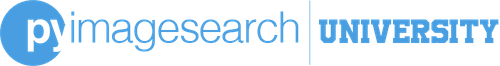

# U-Net Image Segmentation in Keras
Author: Margaret Maynard-Reid ([@margaretmz](https://twitter.com/margaretmz))

This Colab notebook is a U-Net implementation with TensorFlow 2 / Keras, trained for semantic segmentation on the Oxford-IIIT pet dataset. 
It is associated with the [U-Net Image Segmentation in Keras](https://www.pyimagesearch.com/2022/02/21/u-net-image-segmentation-in-keras/), a PyImageSearch blog post published on 2022-02-21. 

You may find this Colab notebooks in the author's GitHub repo [here]().

Here are some helpful resources in case you are unfamiliar with Jupyter notebooks or Colab:
*   [Jupyter Notebook User Interface](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html#notebook-user-interface)
*   [Overview of Google Colaboratory Features](https://colab.research.google.com/notebooks/basic_features_overview.ipynb). 

**Reference:**

This notebook was inspirared by:
* TensorFlow.org [image segmentation tutorial](https://www.tensorflow.org/tutorials/images/segmentation)
* Coursera tensorflow advanced techniques 

Note: Keras.io also has a [U-Net tutorial](https://keras.io/examples/vision/oxford_pets_image_segmentation/) with the Oxford-IIIT pet dataset; however it uses `keras.utils.Sequence` for loading the data and has an Xception-style U-Net architecture. 

## Table of Contents

>[U-Net Image Segmentation in Keras](#scrollTo=LgNY4Ko8sw7q)

>>[Table of Contents](#scrollTo=cY6H4H4SdHJX)

>>[Setup](#scrollTo=53lnZ7YJe5Sw)

>>[Data](#scrollTo=pX631zhEouf4)

>>>[Load dataset from TFDS](#scrollTo=2AR5ZItbpc9R)

>>>[Data preprocessing](#scrollTo=QM9zPoS4phZl)

>>>[Data Visualization](#scrollTo=8zJZHJdc037v)

>>[U-Net Building blocks](#scrollTo=OjBm4atL-i4i)

>>[Build the U-Net Model](#scrollTo=dlcliXVXAk9v)

>>[Compile and Train U-Net](#scrollTo=PG-KtNSWWtWW)

>>[Learning curve from model history](#scrollTo=_bYfxa21Yj0f)

>>[Predictions with U-Net model](#scrollTo=RiG2W81uaS94)



## Setup

In [ ]:
# 라이브러리 불러오기
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#[문제 1] 이 예제에서 사용하는 데이터는 모두 사전에 정리가 되어 있지만 데이터의 상세한 내용을 설명하지는 않았다. 다양한 참고자료를 활용하여 데이터의 특징을 파악하여 분석한 내용을 아래에 추가하시오.

- 37개의 카테고리로 구성된 pet dateset이다.(고양이 2371마리, 강아지 4978마리, 총 7349마리)
- 각 카테고리 별로 200개의 이미지다.
- 이미지 데이터셋은 다양한 scale로 구성되어 있다.
- 모든 이미지에는 annotation이 있어서 품종명(breed), 얼굴 이미지를 파악할 수 있으며 pet과 background를 분할되어 나타난다.
- 파일명이 대문자면 고양이, 소문자면 강아지다.

## Data

### Load dataset from TFDS

In [ ]:
# 데이터 셋 불러오기
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete7KPADI/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete7KPADI/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


Take a look at the dataset info. Note the `test` and `train` data split is already built in the dataset.

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='~/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
        'species': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=Fa

In [ ]:
print(dataset)

{'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>, 'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}


In [ ]:
# train_dataset = pd.DataFrame(dataset["train"])  ## 데이터 셋의 info를 dataframe 형태로 변환
print(dataset["train"])

<PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


#[문제 2] 데이터 전처리과정은 이미지의 용량을 줄이기 위한 resize, 소량의 데이터로 학습량을 늘리기 위한 Augmentation, 그리고 이미지 데이터값을 정규화하기 위한 normalize 함수를 작성해놓았다. 각각의 특징에 대해 살펴보고 분석한 내용을 정리하시오.

- **Resize** : 이미지의 크기를 확대 또는 축소하는 method이며 원래 객체를 그대로 유지한 채 변환된 이미지를 반환한다. 해당 코드에서는 다양한 크기의 input_image와 input_mask 이미지의 가로x세로 길이를 128x128로 맞춰주었다.
- **Augmentation** : rotation 등 이미지에 random한 변화를 적용하여 train set의 다양성을 증가시키는 특징이 있다. 해당 코드에서는 input_image와 input_mask를 좌우반전시켜 데이터의 수를 증가시켰다.
- **Normalize** : 이미지의 데이터 값을 common scale로 만들어 데이터를 더 쉽게 처리할 수 있도록 만듬. 해당 코드에서는 input_image를 -1에서 1사이의 값으로 scaling 하였고 input_mask를 1로 감소시켰다.

### Data preprocessing

In [ ]:
# input data 크기 조정
def resize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (128, 128), method="nearest")
    input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")

    return input_image, input_mask 

In [ ]:
# 사진 data 수 늘리기(augmentation)
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        # Random flipping of the image and mask
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask

In [ ]:
# data 정규화
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
  
    return input_image, input_mask

In [ ]:
# load train images
def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
# load test images
def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [ ]:
# input pipeline 만들기
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
print(train_dataset)

<ParallelMapDataset element_spec=(TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(128, 128, 1), dtype=tf.uint8, name=None))>


Create train, validation and test batches. Note we split the original `test_dataset` into validation and test batches.

In [ ]:
# parameter
BATCH_SIZE = 64
BUFFER_SIZE = 1000

In [ ]:
# split into validation/test sets
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [ ]:
print(train_batches)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>


#[문제 3] 이 부분은 훈련데이터를 시각화하여 보여주기 위한 구문이다. 샘플로 한 개의 영상을 출력하였는데 입력 이미지를 확인해보고 유형별로 한 가지씩 출력시키는 코드를 작성하시오. 유형이 많을 경우에는 다섯 가지의 유형으로 이미지를 출력하시오.

### Data Visualization

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ["Input Image", "True Mask", "Predicted Mask"]

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis("off")
  plt.show()

In [ ]:
sample_batch = next(iter(test_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]

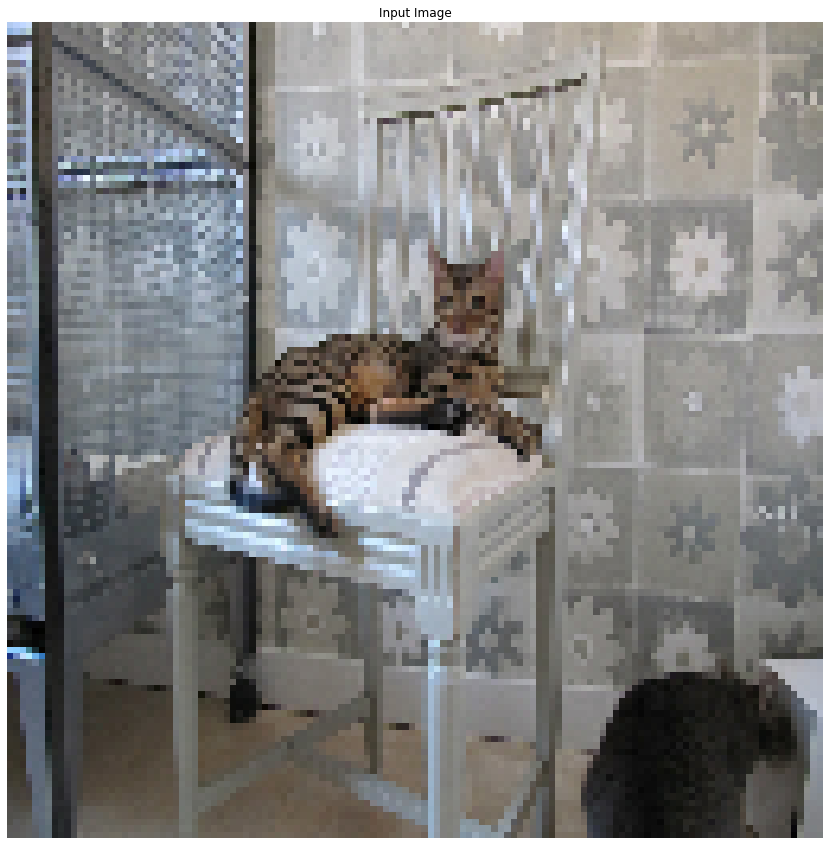

In [ ]:
# 입력 이미지를 확인
display([sample_image])

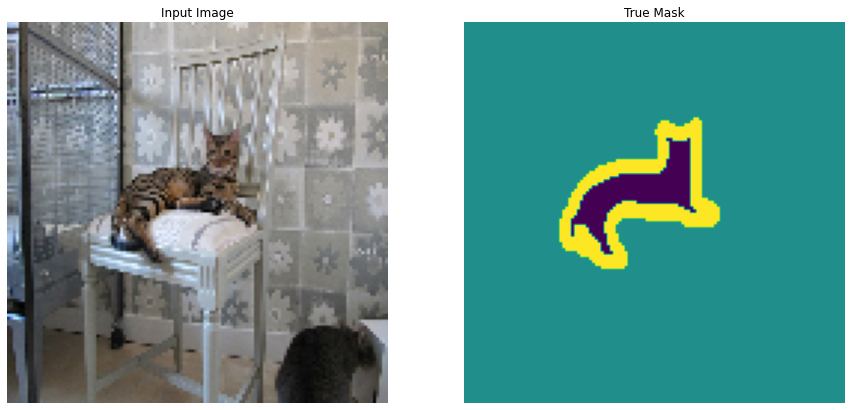

In [ ]:
# 유형별로 한 가지씩 출력
display([sample_image, sample_mask])

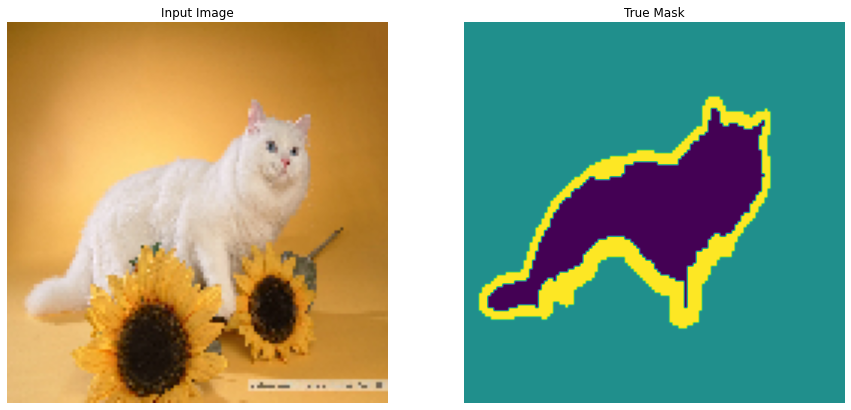

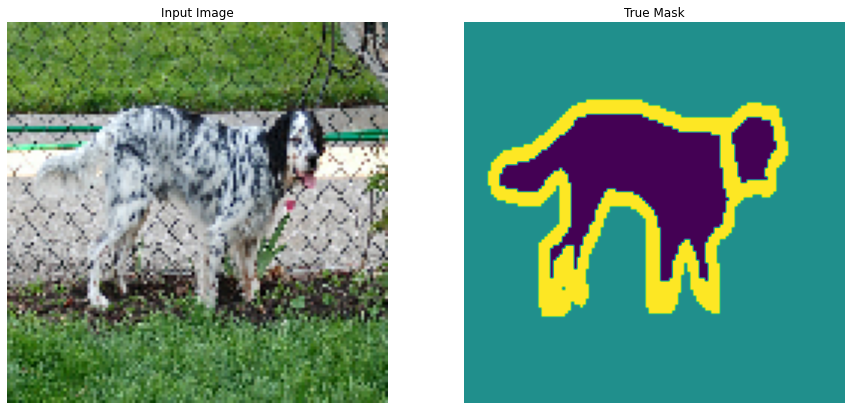

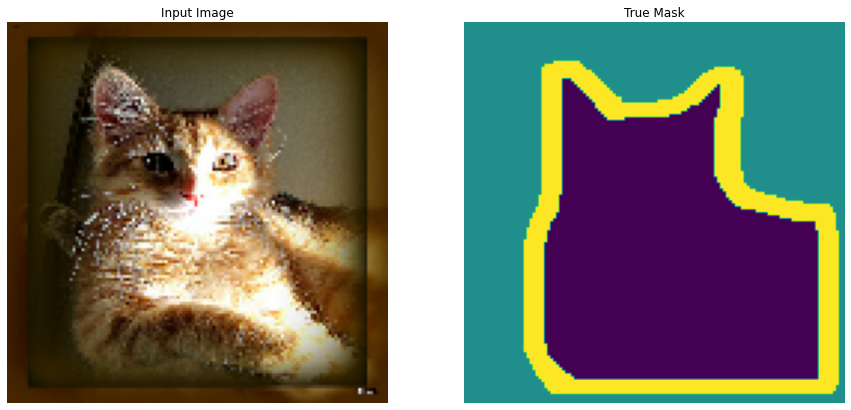

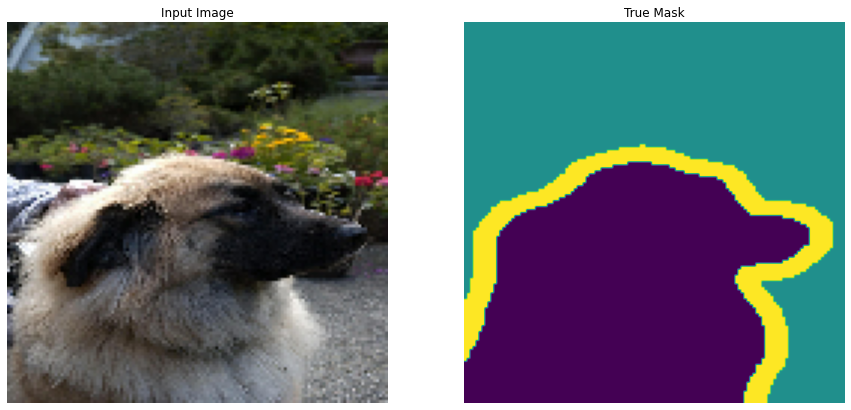

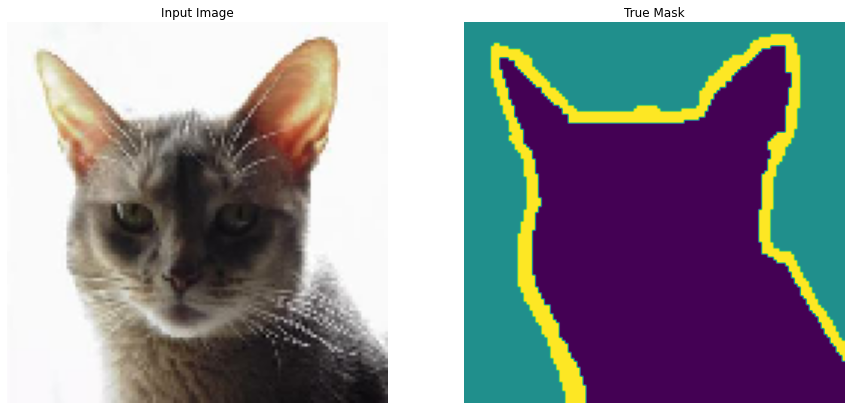

In [ ]:
# 유형이 많을 경우에는 다섯 가지의 유형으로 이미지를 출력
random_index = np.random.choice(sample_batch[0].shape[0], size=5, replace=False)
for i in range(5):
  sample_image, sample_mask = sample_batch[0][random_index[i]], sample_batch[1][random_index[i]]
  display([sample_image, sample_mask]) 

## U-Net Building blocks
Create the building blocks for making the components U-Net model. 

In [ ]:
# relu 함수를 통과하는 max pooling layer
def double_conv_block(x, n_filters):

    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
    # Conv2D then ReLU activation
    x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)

    return x

In [ ]:
# data contraction
def downsample_block(x, n_filters):
    f = double_conv_block(x, n_filters)
    p = layers.MaxPool2D(2)(f)
    p = layers.Dropout(0.3)(p)

    return f, p

In [ ]:
# data expansion
def upsample_block(x, conv_features, n_filters):
    # upsample
    x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
    # concatenate 
    x = layers.concatenate([x, conv_features])
    # dropout
    x = layers.Dropout(0.3)(x)
    # Conv2D twice with ReLU activation
    x = double_conv_block(x, n_filters)
    return x

#[문제 4] 아래 부분이 U-Net의 핵심코드이다. 아래로 내려가면서 Contraction을 수행하고, 다시 위로 올라오면서 Expansion 단계를 수행한다. 이 과정은 U-Net 모델을 구성하는 기본 모델로써 별도로 수정할 부분은 없다. 하지만, epoch 단계를 10으로 줄이고 각 단계별로 Contraction과 Expansion이 이루어지는 과정을 설명하시오.

## Build the U-Net Model

In [ ]:
def build_unet_model():

    # inputs
    inputs = layers.Input(shape=(128,128,3))

    # encoder: contracting path - downsample
    # 1 - downsample
    f1, p1 = downsample_block(inputs, 64)
    # 2 - downsample
    f2, p2 = downsample_block(p1, 128)
    # 3 - downsample
    f3, p3 = downsample_block(p2, 256)
    # 4 - downsample
    f4, p4 = downsample_block(p3, 512)

    # 5 - bottleneck
    bottleneck = double_conv_block(p4, 1024)

    # decoder: expanding path - upsample
    # 6 - upsample
    u6 = upsample_block(bottleneck, f4, 512)
    # 7 - upsample
    u7 = upsample_block(u6, f3, 256)
    # 8 - upsample
    u8 = upsample_block(u7, f2, 128)
    # 9 - upsample
    u9 = upsample_block(u8, f1, 64)

    # outputs
    outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # unet model with Keras Functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")

    return unet_model

In [ ]:
unet_model = build_unet_model()

In [ ]:
unet_model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

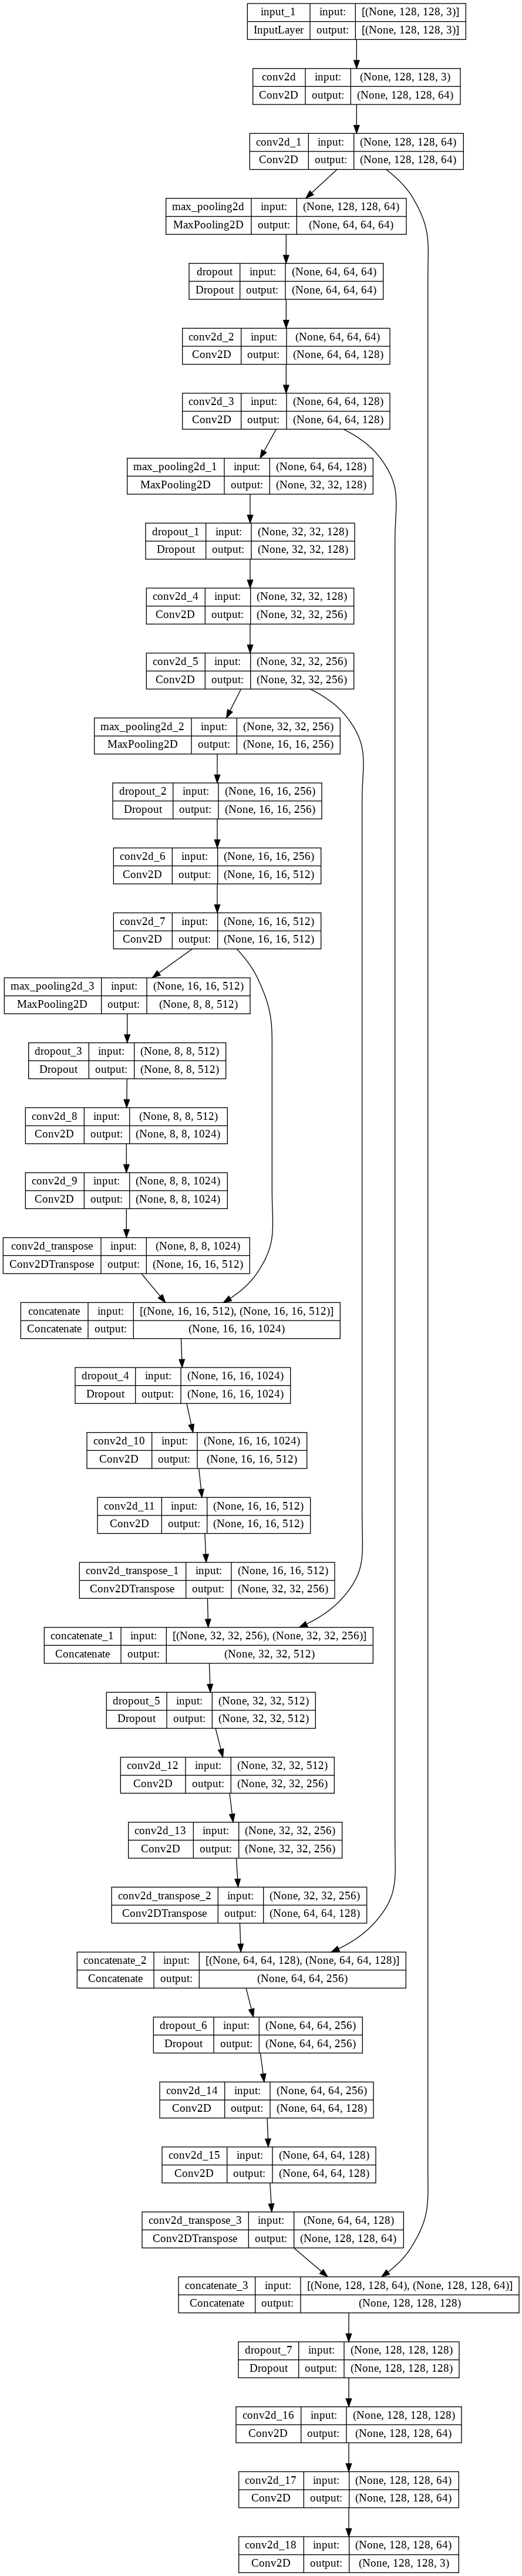

In [ ]:
tf.keras.utils.plot_model(unet_model, show_shapes=True)

## Compile and Train U-Net

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                   loss="sparse_categorical_crossentropy",
                   metrics="accuracy")

In [ ]:
# epoch 단계를 10으로 줄이고
NUM_EPOCHS = 10

TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS

model_history = unet_model.fit(train_batches,
                               epochs=NUM_EPOCHS,
                               steps_per_epoch=STEPS_PER_EPOCH,
                               validation_steps=VALIDATION_STEPS,
                               validation_data=validation_batches)

Epoch 1/10
57/57 [==============================] - 87s 1s/step - loss: 1.1813 - accuracy: 0.5623 - val_loss: 0.9085 - val_accuracy: 0.5733
Epoch 2/10
57/57 [==============================] - 67s 1s/step - loss: 0.8204 - accuracy: 0.6354 - val_loss: 0.7562 - val_accuracy: 0.6980
Epoch 3/10
57/57 [==============================] - 59s 1s/step - loss: 0.7187 - accuracy: 0.7050 - val_loss: 0.6699 - val_accuracy: 0.7291
Epoch 4/10
57/57 [==============================] - 59s 1s/step - loss: 0.6430 - accuracy: 0.7386 - val_loss: 0.6248 - val_accuracy: 0.7481
Epoch 5/10
57/57 [==============================] - 59s 1s/step - loss: 0.6080 - accuracy: 0.7560 - val_loss: 0.5957 - val_accuracy: 0.7619
Epoch 6/10
57/57 [==============================] - 59s 1s/step - loss: 0.5563 - accuracy: 0.7784 - val_loss: 0.5074 - val_accuracy: 0.7995
Epoch 7/10
57/57 [==============================] - 59s 1s/step - loss: 0.5074 - accuracy: 0.8012 - val_loss: 0.4997 - val_accuracy: 0.8066
Epoch 8/10
57/57 [==

### 각 단계별로 Contraction과 Expansion이 이루어지는 과정을 설명하시오.
contraction된 이미지를 max pooling하여 이미지의 feature 값을 추출하고 Expansion을 통해 downsapling된 이미지의 크기를 이전 layer를 통과한 이미지의 크기와 맞춰준다. 해당 방식을 반복하며 이미지 데이터의 feature값을 추출한다.

#[문제 6] 아래 부분은 모델의 수행과정에서 Loss, Accuracy를 시각화하는 단계이다. 예측 결과를 여러 가지 유형의 이미지로 설명하시오.

## Learning curve from model history

In [ ]:
def display_learning_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs_range = range(NUM_EPOCHS)

    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validataion accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc="lower right")

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validataion loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")

    fig.tight_layout()
    plt.show()

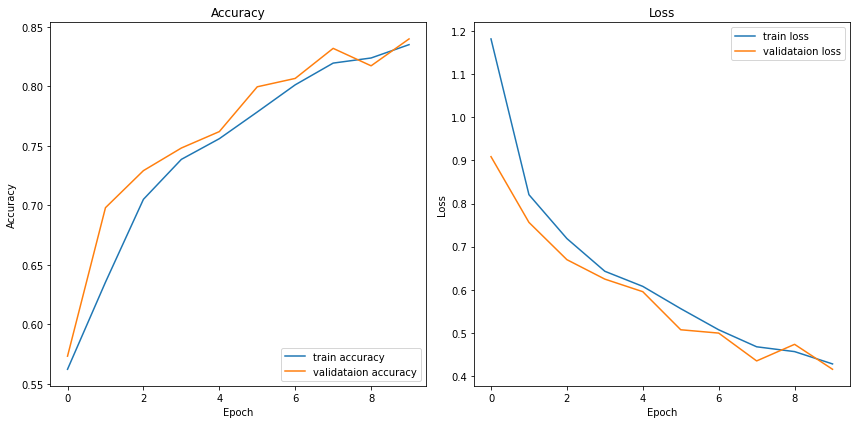

In [ ]:
# Display learning curves 
display_learning_curves(unet_model.history)

## Predictions with U-Net model
Let's try the trained U-Net model on a few samples from the test dataset.

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = unet_model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(unet_model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
count = 0
for i in test_batches:
    count +=1
print("number of batches:", count)

number of batches: 11


2/2 [==============================] - 0s 197ms/step


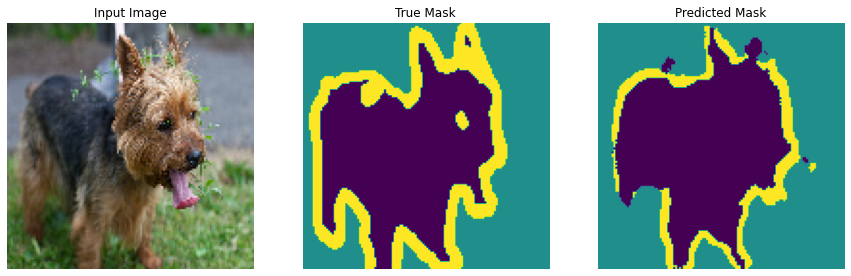

2/2 [==============================] - 0s 131ms/step


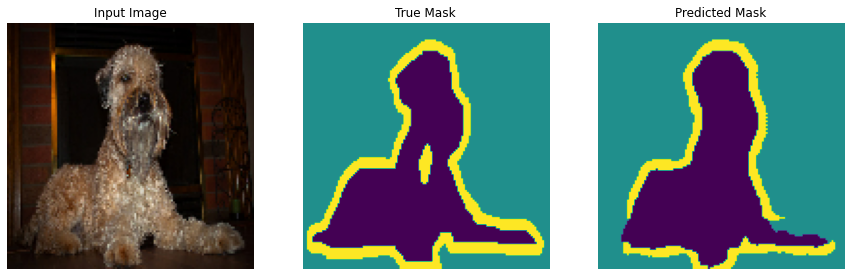

2/2 [==============================] - 0s 155ms/step


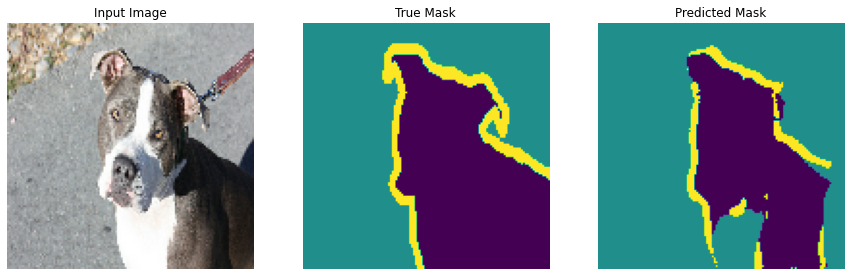

In [ ]:
show_predictions(test_batches.skip(5), 3)

2/2 [==============================] - 0s 195ms/step


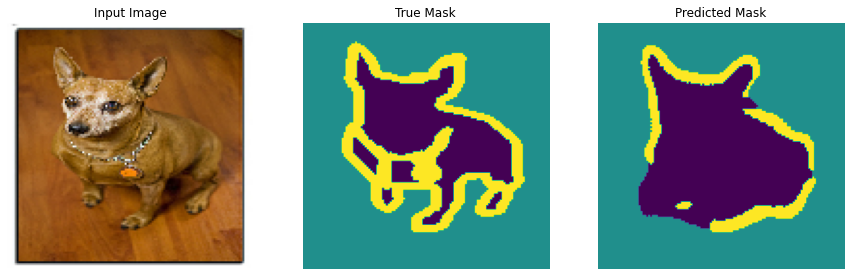

2/2 [==============================] - 0s 156ms/step


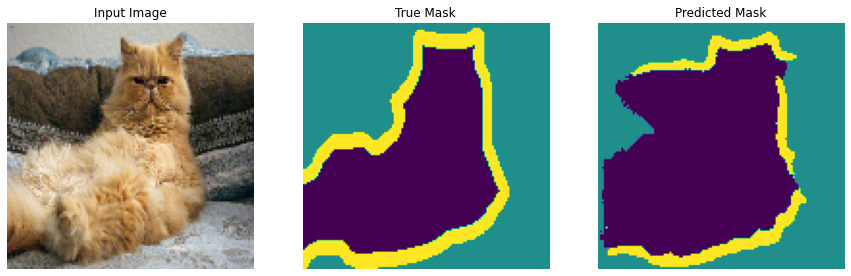

2/2 [==============================] - 0s 157ms/step


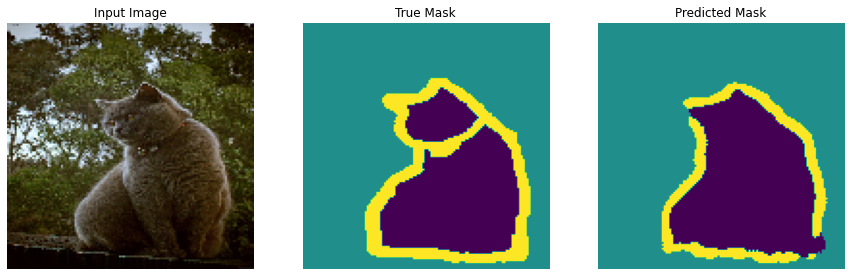

2/2 [==============================] - 0s 155ms/step


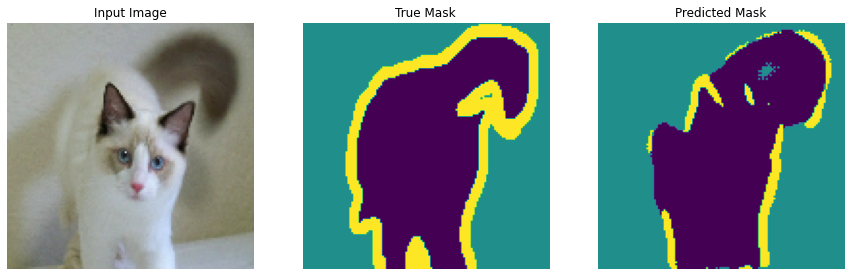

In [ ]:
show_predictions(test_batches, 4)